In [1]:
import os
from google.colab import files, output, drive
drive.mount('/gdrive')
%cd /gdrive
print("You're on Google Colab")
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
    os.chdir('My Drive/--DATA SCIENCE/PROJET4')
!pip install -r requirements_modelling.txt

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


In [2]:
from P4_functions import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import io
from time import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
import warnings
warnings.filterwarnings('ignore')
import dill
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import category_encoders as ce
import scipy.stats as st
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

In [4]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

In [5]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [6]:
path_csv = 'DATA/Cleaned_data.csv' 
# Importing database from my Drive
print("2. Try to import in notebook from myDrive...")

df = pd.read_csv(path_csv, sep=',', index_col='Unnamed: 0',
                 low_memory=True, encoding ='utf-8')

print("-----> importation of .csv in the notebook OK")

2. Try to import in notebook from myDrive...
-----> importation of .csv in the notebook OK


In [7]:
df['ZipCode'] = df['ZipCode'].apply(str).astype('object')
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].apply(str).astype('object')

In [8]:
speak('importations done')

In [9]:
# print("before", df.shape)
# df = df[df['PropertyGFATotal'].between(df['PropertyGFATotal'].mean()-3*df['PropertyGFATotal'].std(),
#                                      df['PropertyGFATotal'].mean()+3*df['PropertyGFATotal'].std())]
# print("after", df.shape)

In [10]:
# print("before", df.shape)
# df = df[df['SiteEnergyUseWN(kBtu)'].between(df['SiteEnergyUseWN(kBtu)'].mean()-3*df['SiteEnergyUseWN(kBtu)'].std(),
#                                      df['SiteEnergyUseWN(kBtu)'].mean()+4*df['SiteEnergyUseWN(kBtu)'].std())]
# print("after", df.shape)

In [11]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
                'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

In [12]:
df_X = df[prop_Q_cols+prop_C_cols]
df_y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

In [13]:
group_col = 'PrimaryPropertyType'

X_tr, X_te, y_tr, y_te = train_test_split(df_X, df_y,
                                            train_size=0.8, shuffle=True,
                                            stratify=df[group_col],
                                            random_state=14)

In [14]:
dict_SEU_models = load_pickle("P4_models_SEU.pkl")
dict_SEU_lcurves = load_pickle("P4_lcurves_SEU.pkl")
dict_SEU_pimp = load_pickle("P4_pimp_SEU.pkl")

--Pickle containing models already existing as  P4_models_SEU.pkl :
 dict_keys(['KNN_log_kneigh_grid', 'KNN_kneigh_grid', 'KNN_kbest_grid', 'KNN_log_kbest_grid', 'Ridge_alpha_enc_rand', 'KNN_pca_grid', 'KNN_log_pca_grid', 'Ridge_log_alpha_enc_rand', 'RandomForest_leaf_nest_grid', 'RandomForest_log_leaf_nest_grid', 'SVR_lin e_c_rand', 'KNN_xout_kneigh_grid', 'Ridge_log_alpha_enc_grid'])
Content loaded from ' P4_models_SEU.pkl '.
--Pickle containing models already existing as  P4_lcurves_SEU.pkl :
 dict_keys(['KNN_kneigh_grid', 'KNN_log_kneigh_grid'])
Content loaded from ' P4_lcurves_SEU.pkl '.
--Pickle containing models already existing as  P4_pimp_SEU.pkl :
 dict_keys(['KNN_kneigh_grid', 'KNN_log_kneigh_grid', 'Ridge_alpha_enc_rand', 'Ridge_log_alpha_enc_grid'])
Content loaded from ' P4_pimp_SEU.pkl '.


In [15]:
df_res = pd.DataFrame(dtype = 'object')

In [16]:
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

In [17]:
dict_models = dict_SEU_models
dict_lcurves = dict_SEU_lcurves
dict_pimp = dict_SEU_pimp

In [18]:
models_file_name = 'P4_models_SEU_2.pkl'
l_curves_file_name = 'P4_l_curves_SEU_2.pkl'
perm_imp_file_name = 'P4_models_SEU_2.pkl'

# MODELS

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
name_reg = 'KNN_2_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, _, _, _ = \
        set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)
'''-----Model not existing - computing...
Grid
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished
-----...model dumped'''

-----Model not existing - computing...
Grid
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
exception calling callback for <Future at 0x7feb3f8512e8 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'P4_functions'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/

BrokenProcessPool: ignored

In [ ]:
# name_reg = 'Ridge_alpha_enc_rand'

In [ ]:
# dict_models[name_reg].best_params_

Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

In [ ]:
# scv = dict_models[name_reg]
# plot_scv_multi_scores(name_reg, scv, param = name_reg+'__alpha',
#                       title = None, figsize = (15, 3))

In [ ]:
# param1 = name_reg+'__'+'n_neighbors'
# param2 = name_reg+'__'+'p'
# params = [param1, param2]

# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=params,
#                        score = 'r2')

In [ ]:
# # del dict_lcurves[name_reg] # to overwrite an existing learning curve
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# # title = f"Learning Curves ({name_reg})"
# model = dict_models[name_reg].best_estimator_
# plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
#                     cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
#                     file_name=l_curves_file_name,
#                     dict_learn_curves=dict_lcurves,
#                     train_sizes = np.linspace(0.1,1,15),
#                     c='b', axes=axes, title=None)
# plt.show()

#### Dealing with outliers...

- élimination via zscore (réglage du seuil)
- élimination via IsolationForest
- aiguillage vers 2 modèles en utilisant IsolationForest

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsRegressor

# reg = KNeighborsRegressor()
# name_reg = 'KNN_xout_kneigh_grid'
# # del dict_models[name_reg] # to overwrite an existing model
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#             'x_outliers__neg_conf_val': [-4], # [-1,-2,-5,-10,-20,-50,-100]
#             'x_outliers__n_neighbors': [5,10,20], # [5,10,20,50]
#             name_reg+'__n_neighbors': [7], # 1,3,4,5,7,9,11,15,17
#             name_reg+'__p': [1]} # 1,2
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
# pipe = Pipeline([('preproc', preproc_pipe),
#                  ('x_outliers', X_OutlierExtractor()),
# 	             (name_reg, reg)])
# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)


In [ ]:
# print(dict_scv_params['X'].shape)
# X = preproc_pipe.fit_transform(dict_scv_params['X'])
# for i in range(-10,-1):
#     xout = X_OutlierExtractor(neg_conf_val=i)
#     print(i, X.shape, xout.fit_transform(X).shape, type(xout.fit_transform(X)))

In [ ]:
# scv = dict_models[name_reg]
# plot_scv_multi_scores(name_reg, scv, param = 'x_outliers__neg_conf_val',
#                       title = None, figsize = (15, 3))

In [324]:
dict_models[name_reg].get_params()

{'cv': [(array([  94,  168,  169, ..., 1317, 1318, 1319]),
   array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
           13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
           26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
           39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
           52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
           65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
           78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
           91,  92,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
          105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
          118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
          131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
          144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
          157, 158, 159, 160, 161, 162, 1

In [326]:
dict_models.keys()

dict_keys(['KNN_log_kneigh_grid', 'KNN_kneigh_grid', 'KNN_kbest_grid', 'KNN_log_kbest_grid', 'Ridge_alpha_enc_rand', 'KNN_pca_grid', 'KNN_log_pca_grid', 'Ridge_log_alpha_enc_rand', 'RandomForest_leaf_nest_grid', 'RandomForest_log_leaf_nest_grid', 'SVR_lin e_c_rand', 'KNN_xout_kneigh_grid', 'Ridge_log_alpha_enc_grid', 'Ridge_alpha_enc_grid'])

In [325]:
name_reg = 'KNN_kbest_grid'

param1 = name_reg+'__'+'n_neighbors'
param4 = 'feat_sel__k_best__score_func'
param5 = 'feat_sel__k_best__k'

# fig = plt.figure(figsize=(20,3))
# ax = fig.add_subplot(1,2,1)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param2],
#                        score = 'r2', ax=ax)
# ax = fig.add_subplot(1,4,2)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param3],
#                        score = 'r2', ax=ax)
# ax = fig.add_subplot(1,2,1)
plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param4],
                       score = 'r2', ax=None)
# ax = fig.add_subplot(1,2,2)
# plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=[param1, param5],
#                        score = 'r2', ax=ax)

TypeError: ignored

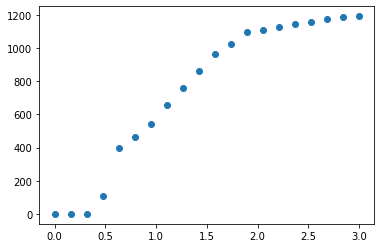

In [312]:
### PROBLEME AVEC LES NOMS DES FEATURES ET LA RECUPERATION D'UNE DATAFRAME APRES ENCODAGE

# ct = CustTransformer(thresh_card=12, strat_binary='ord',
#                      strat_low_card='ohe', strat_high_card='bin',
#                      strat_quant='stand')
# ct.fit(df_test)
# ct.cat_trans.fit(df_test)
# ct.cat_trans.get_feature_names()

df_test = X_tr.select_dtypes(include=[np.number]).copy('deep')
df_test.shape
# Seuillage des données d'apprentissage en se basant sur le zscore (partie numérique seulement)
tab_shape=[]
for t in np.linspace(0.001,3,20):
    zsf = ZscoreSampleFilter(thresh=t)
    zsf.fit(df_test)
    df_test_mod = zsf.fit_transform(df_test)
    tab_shape.append(df_test_mod.shape[0])

plt.scatter(np.linspace(0.001,3,20), tab_shape)

In [267]:
zsf = ZscoreSampleFilter(thresh=3)
zsf.fit(df_truc)

df_truc = pd.DataFrame({'a': np.arange(10), 'b': np.arange(10,20)})
df_truc_filt = zsf.fit_transform(df_truc)
display(df_truc, df_truc_filt)

,a,b
0,0,10
1,1,11
2,2,12
3,3,13
4,4,14
5,5,15
6,6,16
7,7,17
8,8,18
9,9,19


,a,b
0,0,10
1,1,11
2,2,12
3,3,13
4,4,14
5,5,15
6,6,16
7,7,17
8,8,18
9,9,19


In [234]:
class ZscoreSampleFilter(BaseEstimator, TransformerMixin):
    def __init__(self, thresh = None):
        self.thresh = thresh

    def fit(self, X, y=None):
        self.X_zscore = X.apply(st.zscore, axis=0)
        # self.featurefilter = [True for c in X.columns] # pas de filtrage de colonnes
        self.samplefilter = (np.abs(self.X_zscore)<self.thresh).all(1) # filtrage de lignes
        return self

    def transform(self, X, y=None, copy=None):
        # X_mod = X.loc[:,self.featurefilter]
        X_mod = X.loc[self.samplefilter]
        if y is not None:
            y_mod = y.loc[self.samplefilter]
            return X_mod, y_mod
        else:
            return X_mod

    def fit_transform(self, X, y=None, **fit_params):
        if y is None:
            return self.fit(X, **fit_params).transform(X)
        else:
            return self.fit(X, y, **fit_params).transform(X,y)


"""  
Class to filter outliers from X and y from a LOF analysis on X
(CANNOT BE USED IN A PIPELINE !!!)
A threshold is set for selection criteria, 
neg_conf_val (float): threshold for excluding samples with a lower
               negative outlier factor.
"""

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class LOFSampleFilter(BaseEstimator, TransformerMixin):
    def __init__(self, neg_conf_val=None, n_neighbors=None, **kwargs):
        self.neg_conf_val = neg_conf_val if neg_conf_val is not None else -10
        self.n_neighbors = n_neighbors if n_neighbors is not None else 20
        self.kwargs = kwargs

    def fit(self, X, y=None, *args, **kwargs):
        # X = np.asarray(X)
        # y = np.asarray(y)
        lcf = LocalOutlierFactor(n_neighbors=self.n_neighbors, **self.kwargs)
        lcf.fit(X)
        # self.featurefilter = [True for c in X.columns] # pas de filtrage de colonnes
        self.samplefilter = lcf.negative_outlier_factor_ > self.neg_conf_val # filtrage de lignes
        return self

    def transform(self, X, y=None, copy=None):
        # X_mod = X.loc[:,self.featurefilter]
        X_mod = X.loc[self.samplefilter]
        if y is not None:
            y_mod = y.loc[self.samplefilter]
            return X_mod, y_mod
        else:
            return X_mod

    def fit_transform(self, X, y=None, **fit_params):
        if y is None:
            return self.fit(X, **fit_params).transform(X)
        else:
            return self.fit(X, y, **fit_params).transform(X,y)


In [ ]:
reg = KNeighborsRegressor()
name_reg = 'KNN_xout_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            # 'x_outliers__neg_conf_val': [-4], # [-1,-2,-5,-10,-20,-50,-100]
            # 'x_outliers__n_neighbors': [5,10,20], # [5,10,20,50]
            name_reg+'__n_neighbors': [7], # 1,3,4,5,7,9,11,15,17
            name_reg+'__p': [1]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
                # ('filter', SampleAndFeatureFilter()),
                # ('x_outliers', X_OutlierExtractor()),
	            (name_reg, reg)])
dict_scv_params, _, _, _ = \
        set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
name_reg = 'KNN_2_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, _, _, _ = \
        set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)
'''-----Model not existing - computing...
Grid
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished
-----...model dumped'''